In [1]:

# import sys
# !{sys.executable} -m pip install 
# import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
raw_dataset = pd.read_csv("~/data/glac/T_models/T.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/data/T.csv")

dataset = raw_dataset.copy()

#examine data columns
dataset.head()

2.7.0


,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,GLACIER_DB,GLACIER_ID,LAT,LON,SURVEY_DATE,ELEVATION_DATE,AREA,...,SURVEY_METHOD_DETAILS,NUMBER_OF_SURVEY_POINTS,NUMBER_OF_SURVEY_PROFILES,TOTAL_LENGTH_OF_SURVEY_PROFILES,INTERPOLATION_METHOD,INVESTIGATOR,SPONSORING_AGENCY,REFERENCES,DATA_FLAG,REMARKS
0,1,SE,ISFALLSGLAC,WGI,SE4B000E0006,67.91500,18.56800,19790399.0,19799999.0,1.3,...,NaN,NaN,NaN,NaN,NaN,Schytt V. and others,University of Iceland,"Björnsson, H., (1981). Geogr. Ann.",NaN,NaN
1,2,SE,RABOTS GLACIAER,WGI,SE4B000E1016,67.91000,18.49600,19790399.0,19799999.0,4.1,...,NaN,NaN,10.0,NaN,NaN,Schytt V. and others,University of Iceland,"Björnsson, H., (1981). Geogr. Ann.",NaN,NaN
2,3,SE,STORGLACIAEREN,WGI,SE4B000E0005,67.90000,18.57000,19790399.0,19799999.0,3.1,...,NaN,NaN,NaN,NaN,NaN,Schytt V. and others,University of Iceland,"Björnsson, H., (1981). Geogr. Ann.",NaN,NaN
3,4,US,SOUTH CASCADE,WGI,US2M00264006,48.35698,-121.05735,19759999.0,19759999.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Driedger, C.L., and Kennard, P.M., (1986a). An...",NaN,NaN
4,5,CA,ATHABASCA,FOG,7,52.17540,-117.28400,NaN,NaN,3.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Driedger, C.L., and Kennard, P.M., (1986a). An...",NaN,NaN


In [2]:
#drop everything but lat, long, elevation, thickness
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

dataset_saved_for_later = dataset


dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GlaThiDa_ID", axis=1)
#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()


LAT               0
LON               0
AREA              0
MEAN_SLOPE        0
MEAN_THICKNESS    0
dtype: int64

In [3]:
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


In [4]:
# len(dataset["GLACIER_NAME"].unique())

In [5]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=1)
test_dataset = dataset.drop(train_dataset.index)

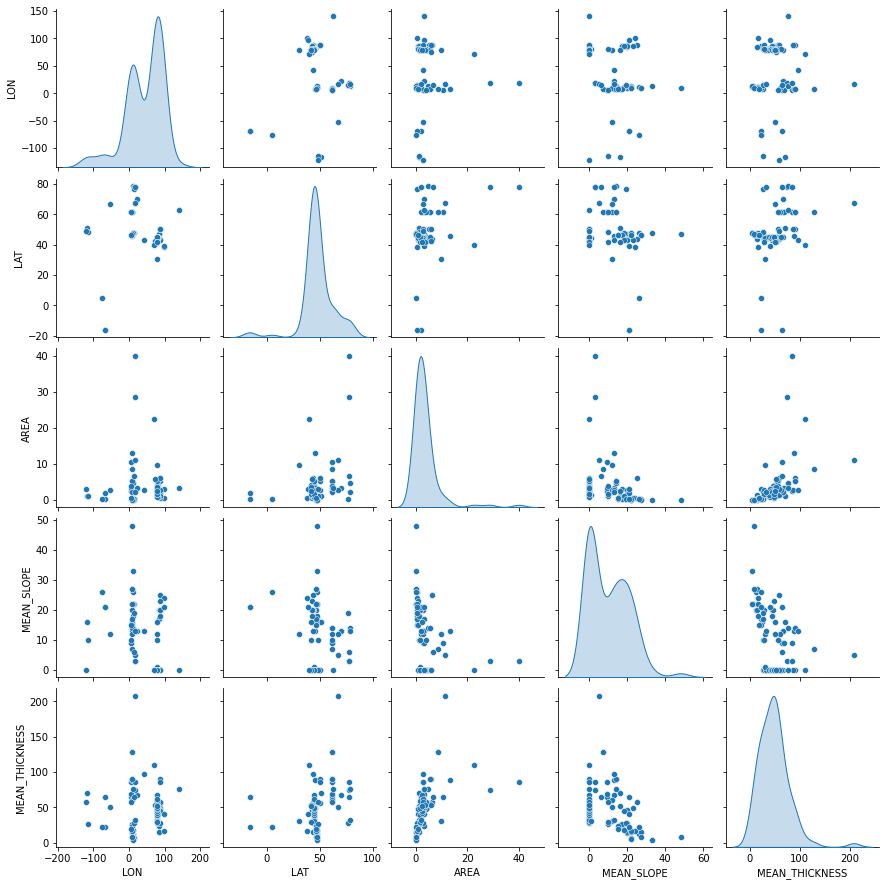

In [6]:
sns.pairplot(train_dataset[["LON","LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [7]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.805461,14.969416,-16.3023,44.580400,44.95518,48.75000,78.87100
LON,89.0,43.089345,52.483122,-121.8300,9.255655,78.27280,80.12033,140.86536
AREA,89.0,3.545828,5.804720,0.0264,1.000000,2.10000,3.28000,39.96000
MEAN_SLOPE,89.0,9.988764,10.381906,0.0000,0.000000,9.00000,18.00000,48.00000
MEAN_THICKNESS,89.0,48.550562,30.407838,4.0000,27.000000,48.00000,60.00000,208.00000


In [8]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.805461,14.969416
LON,43.089345,52.483122
AREA,3.545828,5.804720
MEAN_SLOPE,9.988764,10.381906


# Establish normalization layers

In [9]:
normalizer = {}
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

2022-03-11 14:34:30.314104: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-11 14:34:30.314177: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-11 14:34:30.314634: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Single variable linear regression functions

In [10]:
# glacierml

def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error")
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel("Avg Thickness (m)")
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [11]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [12]:
%%time
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

CPU times: user 2min 9s, sys: 1min 11s, total: 3min 20s
Wall time: 1min 48s


{'AREA': 101.69666290283203,
 'LAT': 24.345531463623047,
 'LON': 25.209461212158203,
 'MEAN_SLOPE': 23.09484100341797}

In [13]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


    Variable      loss   val_loss
999     AREA  18.47669  16.610361

    Variable       loss   val_loss
999      LAT  18.329288  24.540257

    Variable       loss   val_loss
999      LON  20.539448  25.667324

       Variable       loss   val_loss
999  MEAN_SLOPE  19.838268  13.254679



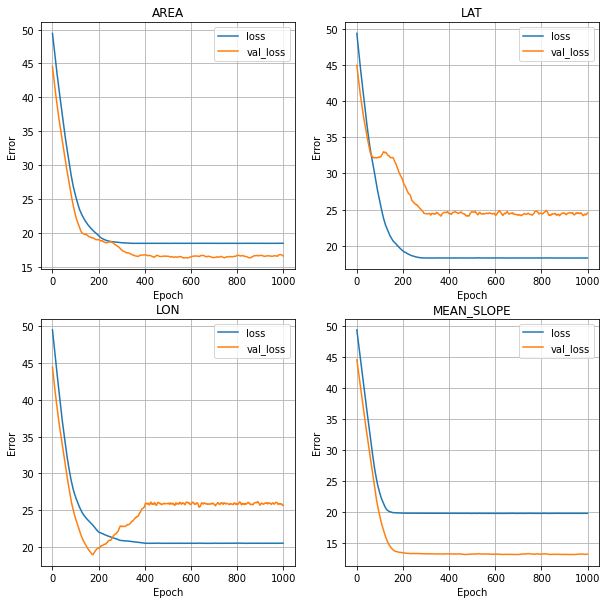

In [14]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,2,i+1)
    plt.subplot(2,2,i+1)
    plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

In [15]:
# thiswillcrash()

# Linear regression with multiple inputs

In [16]:
linear_model = build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'MULTI': 55.795265197753906}

In [17]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



           Variable       loss   val_loss
999  Multi-Variable  16.151045  22.707747


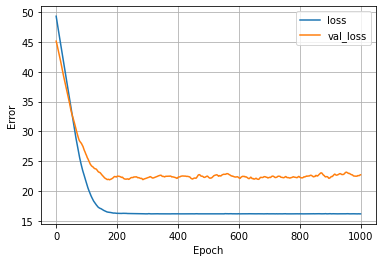

In [18]:
plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [19]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [20]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [21]:
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

{'AREA': 41.353023529052734,
 'LAT': 20.694643020629883,
 'LON': 25.279417037963867,
 'MEAN_SLOPE': 20.09856414794922}

In [22]:
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')

for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


    Variable       loss   val_loss
999     AREA  14.192415  13.089435

    Variable       loss   val_loss
999      LAT  13.302599  16.864647

    Variable      loss   val_loss
999      LON  20.06262  27.668657

       Variable       loss   val_loss
999  MEAN_SLOPE  16.794418  14.739635



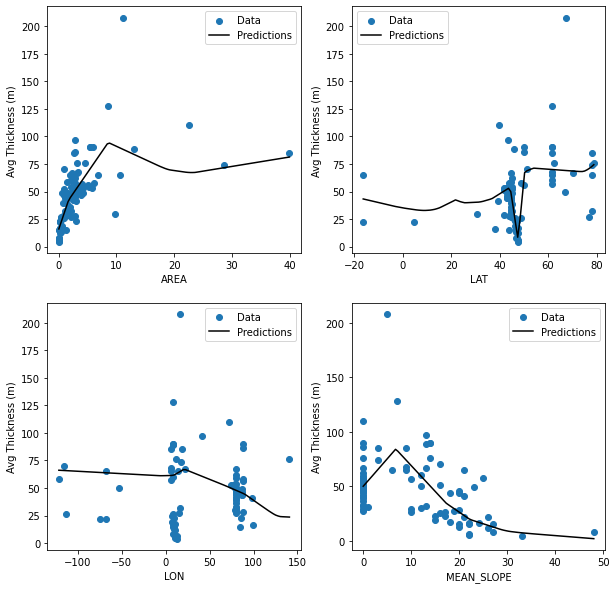

In [23]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

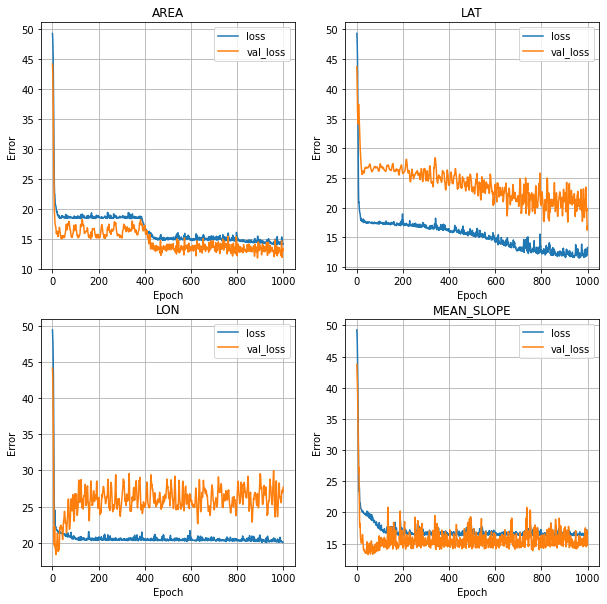

In [24]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [25]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [26]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 49.7 s, sys: 23 s, total: 1min 12s
Wall time: 27.4 s


In [27]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


           Variable      loss   val_loss
999  Multi-Variable  6.399158  31.204617


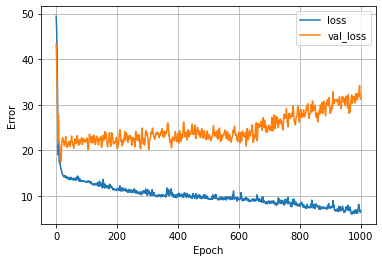

In [28]:
plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 120.0)

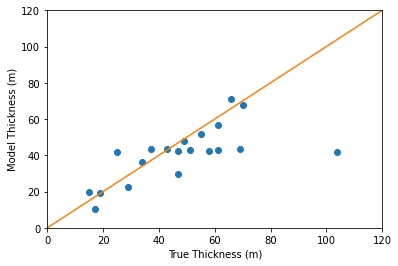

In [29]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,"o")
plt.plot((0,120),(0,120),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,120))
plt.ylim((0,120))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

In [67]:
#split the dataset and reserve some to test what was trained.
# train_dataset = dataset.sample(frac=0.8, random_state=1)
# test_dataset = dataset.drop(train_dataset.index)


RGI = pd.read_csv("/home/sa42/data/glac/glims/glims_extra/dump2/01_rgi60_Alaska.csv")
RGI = RGI.drop("RGIId", axis=1)
RGI = RGI.drop("GLIMSId", axis=1)
RGI = RGI.drop("BgnDate", axis=1)
RGI = RGI.drop("EndDate", axis=1)
RGI = RGI.drop("O1Region", axis=1)
RGI = RGI.drop("O2Region", axis=1)
# RGI = RGI.drop("Zmin", axis=1)
RGI = RGI.drop("Zmed", axis=1)
# RGI = RGI.drop("Zmax", axis=1)
RGI = RGI.drop("Aspect", axis=1)
RGI = RGI.drop("Lmax", axis=1)
RGI = RGI.drop("Status", axis=1)
RGI = RGI.drop("Connect", axis=1)
RGI = RGI.drop("Form", axis=1)
RGI = RGI.drop("TermType", axis=1)
RGI = RGI.drop("Surging", axis=1)
RGI = RGI.drop("Linkages", axis=1)
RGI = RGI.drop("Name", axis=1)
RGI.rename(columns = {"CenLon":"LON",
                      "CenLat":"LAT",
                      "Area":"AREA",
                      "Slope":"MEAN_SLOPE"},
           inplace = True)
RGI

,LON,LAT,AREA,Zmin,Zmax,MEAN_SLOPE
0,-146.823000,63.689000,0.360,1936,2725,42.0
1,-146.668000,63.404000,0.558,1713,2144,16.0
2,-146.080000,63.376000,1.685,1609,2182,18.0
3,-146.120000,63.381000,3.681,1273,2317,19.0
4,-147.057000,63.551000,2.573,1494,2317,16.0
...,...,...,...,...,...,...
27103,-143.726807,60.231728,534.228,3,3238,10.0
27104,-143.084000,60.532000,0.515,2448,3034,40.0
27105,-129.512000,54.595900,3.564,980,1761,23.5
27106,-129.548000,54.620600,1.414,1314,1823,27.1


In [35]:
# dataset_saved_for_later


# dataset_saved_for_later = dataset_saved_for_later.drop("GLACIER_ID", axis=1)
# dataset_saved_for_later = dataset_saved_for_later.drop("GlaThiDa_ID", axis=1)
# #drop the remaining null pieces from elevation
# dataset_saved_for_later = dataset_saved_for_later.dropna()
# dataset_saved_for_later.isna().sum()
dataset_saved_for_later

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


In [46]:
test_features

,LAT,LON,AREA,MEAN_SLOPE
33,58.380000,-134.360000,11.70000,0.0
37,50.050300,87.788600,0.75000,0.0
38,41.786810,77.749270,1.18000,0.0
41,41.827300,78.204930,11.32000,0.0
43,43.050000,77.080000,2.72000,0.0
44,38.767000,72.283000,824.00000,0.0
48,45.235130,80.808350,3.40000,0.0
50,44.883000,79.285000,2.00000,0.0
52,44.917000,79.317000,1.20000,0.0
57,44.970000,79.530000,2.00000,0.0


In [47]:
y_alaska_test = dnn_full_model.predict(RGI)

(-200.0, 300.0)

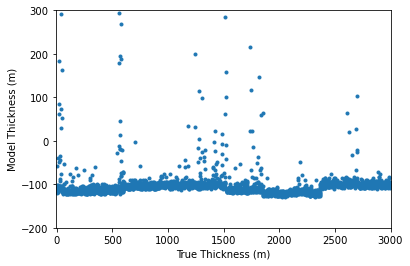

In [81]:
plt.plot(y_alaska_test,".")
# plt.plot((0,1000),(0,1000),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((-10,3000))
plt.ylim((-200,300))

In [55]:
print(y_alaska_test)

[[-103.134]
 [-120.336]
 [-113.588]
 ...
 [ -80.767]
 [ -89.438]
 [-103.799]]
